<div><center><img src="https://ml.ucv.ai/logo.png\" width=150"/> </center></div>

# 04 Segmentación de imágenes con redes U-Net


Basado en:

- [Efficient Image Segmentation](https://medium.com/data-science/efficient-image-segmentation-using-pytorch-part-3-3534cf04fb89)
- [Image segmentation with a U-Net-like architecture](https://keras.io/examples/vision/oxford_pets_image_segmentation/)



# 1. Arquitecturas Encoder-Decoder (Teoría y Fórmulas)

Un modelo **encoder-decoder** transforma una entrada $ \mathbf{x} \in \mathbb{R}^n $ en una salida $ \mathbf{y} \in \mathbb{R}^m $ mediante una representación latente $ \mathbf{z} \in \mathbb{R}^d $, donde normalmente $ d < n $.

## 1.1 Encoder

El **encoder** convierte la entrada $ \mathbf{x} $ en una representación latente $ \mathbf{z} $:

$$
\mathbf{z} = f_{\text{enc}}(\mathbf{x}; \theta_e)
$$

- $ f_{\text{enc}} $: red neuronal (CNN, RNN, MLP, etc.)
- $ \theta_e $: parámetros del encoder
- $ \mathbf{z} $: vector latente comprimido

Si el encoder tiene múltiples capas:

$$
\mathbf{z} = f_L \circ f_{L-1} \circ \dots \circ f_1(\mathbf{x})
$$

En términos de dominio y codominio:

$$
f_{\text{enc}}: \mathbb{R}^n \rightarrow \mathbb{R}^d
$$

- $ \mathbf{x} \in \mathbb{R}^n $: entrada original
- $ \mathbf{z} = f_{\text{enc}}(\mathbf{x}) \in \mathbb{R}^d $: representación latente
- Típicamente $ d < n $ para compresión


## 1.2. Decoder

El **decoder** reconstruye o genera la salida a partir de $ \mathbf{z} $:

$$
\hat{\mathbf{y}} = f_{\text{dec}}(\mathbf{z}; \theta_d)
$$

- $ f_{\text{dec}} $: red decodificadora
- $ \theta_d $: parámetros del decoder
- $ \hat{\mathbf{y}} $: salida generada o reconstruida

Reconstruye o genera la salida desde el espacio latente:

$$
f_{\text{dec}}: \mathbb{R}^d \rightarrow \mathbb{R}^m
$$

- $ \mathbf{z} \in \mathbb{R}^d $: vector latente
- $ \hat{\mathbf{y}} = f_{\text{dec}}(\mathbf{z}) \in \mathbb{R}^m $: salida reconstruida o generada


## 1.3. El modelo

El modelo completo es la composición de encoder y decoder:

$$
f_{\text{dec}} \circ f_{\text{enc}}: \mathbb{R}^n \rightarrow \mathbb{R}^m
$$

Es decir:

$$
\hat{\mathbf{y}} = f_{\text{dec}}(f_{\text{enc}}(\mathbf{x}))
$$


## 1.4. Función de Pérdida

El modelo se entrena minimizando la pérdida entre la salida generada $ \hat{\mathbf{y}} $ y la salida real $ \mathbf{y} $:

$$
\mathcal{L}(\mathbf{y}, \hat{\mathbf{y}}) = \mathcal{L}\left(\mathbf{y}, f_{\text{dec}}(f_{\text{enc}}(\mathbf{x}))\right)
$$

### Ejemplos comunes:

- **Reconstrucción (autoencoder):**

$$
\mathcal{L} = \|\mathbf{x} - f_{\text{dec}}(f_{\text{enc}}(\mathbf{x}))\|^2
$$

- **Segmentación (por píxel):**

$$
\mathcal{L} = \text{CrossEntropy}(\mathbf{y}, \hat{\mathbf{y}})
$$

- **Secuencia a secuencia (traducción):**

$$
\mathcal{L} = -\sum_{t=1}^T \log P(y_t \mid \mathbf{z}, y_{<t})
$$



## 1.4. Optimización

El entrenamiento ajusta los parámetros del modelo $ \theta = \{\theta_e, \theta_d\} $ para minimizar la pérdida esperada:

$$
\theta^* = \arg \min_{\theta} \ \mathbb{E}_{(\mathbf{x}, \mathbf{y}) \sim \mathcal{D}} \left[ \mathcal{L}(\mathbf{y}, f_{\text{dec}}(f_{\text{enc}}(\mathbf{x}))) \right]
$$

Donde $ \mathcal{D} $ es el conjunto de datos de entrenamiento.



# 3. Segmentación

In [ ]:
!pip install torchinfo

In [1]:
import torch
from torch import nn
import os
from os import path
import torchvision
import torchvision.transforms as T
from typing import Sequence
from torchvision.transforms import functional as F
import numbers
import random
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from dataclasses import dataclass
import dataclasses
from torchinfo import summary

#rafael: agregue esto ya que estoy usando mi maquina local
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

# Get GPU devices
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    tf.config.experimental.set_memory_growth(gpus[0], True)
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=3000)]
    )

# rafael: agregue esto porque comence a usar mi propia maquina
torch.cuda.is_available()

2025-07-21 14:13:26.902620: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-21 14:13:26.920239: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753121606.933751   60953 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753121606.937577   60953 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1753121606.947574   60953 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


True

In [2]:
# Convert a pytorch tensor into a PIL image
t2img = T.ToPILImage()
# Convert a PIL image into a pytorch tensor
img2t = T.ToTensor()

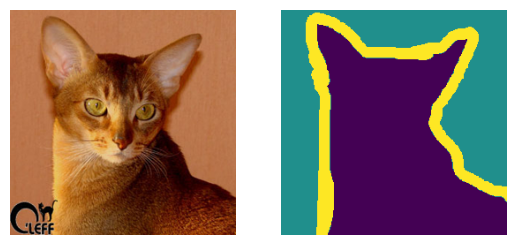

In [3]:
import requests

def get_unsplash_image():
    image_path = "stroller-unsplash.avif"

    if not os.path.exists(image_path):
        url = "https://images.unsplash.com/photo-1687017563985-a7193fcd7032"
        r = requests.get(url, allow_redirects=True)
        with open(image_path, 'wb') as fp:
            fp.write(r.content)
        # end with
    # end if

    image_256_path = "stroller-unsplash-256.png"

    if not os.path.exists(image_256_path):
        img = Image.open(image_path)
        img = img.resize((256, 256))
        img = img.convert("RGB")
        img.save(image_256_path)
    # end if

    img = Image.open(image_256_path)
    return img

def get_pet_cat_image_and_mask():
    img = Image.open(r"images/Abyssinian_169.jpg")
    img = img.convert("RGB").resize((256, 256))

    mask = Image.open(r"annotations/trimaps/Abyssinian_169.png")
    mask = mask.convert("L").resize((256, 256))
    mask = t2img((img2t(mask) * 255. - 1.) / 2.)
    return img, mask

img, mask = get_pet_cat_image_and_mask()

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(mask)
plt.axis("off")

plt.show()

## 3.2 Descargar los datos

In [ ]:
#!!wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
#!!wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz

In [ ]:
#!tar -xf images.tar.gz
#!tar -xf annotations.tar.gz

## 3.3 Preparar los nombres de las imágenes y las máscaras

In [4]:
import os

input_dir = "images/"
target_dir = "annotations/trimaps/"
img_size = (160, 160)
num_classes = 3
batch_size = 32

input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".jpg")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

print("Número de imágenes:", len(input_img_paths))

for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)

Número de imágenes: 7390
images/Abyssinian_1.jpg | annotations/trimaps/Abyssinian_1.png
images/Abyssinian_10.jpg | annotations/trimaps/Abyssinian_10.png
images/Abyssinian_100.jpg | annotations/trimaps/Abyssinian_100.png
images/Abyssinian_101.jpg | annotations/trimaps/Abyssinian_101.png
images/Abyssinian_102.jpg | annotations/trimaps/Abyssinian_102.png
images/Abyssinian_103.jpg | annotations/trimaps/Abyssinian_103.png
images/Abyssinian_104.jpg | annotations/trimaps/Abyssinian_104.png
images/Abyssinian_105.jpg | annotations/trimaps/Abyssinian_105.png
images/Abyssinian_106.jpg | annotations/trimaps/Abyssinian_106.png
images/Abyssinian_107.jpg | annotations/trimaps/Abyssinian_107.png


## 3.4 Cargando las imágenes usando Keras

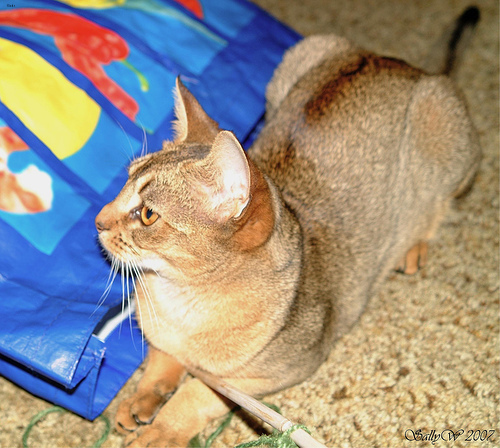

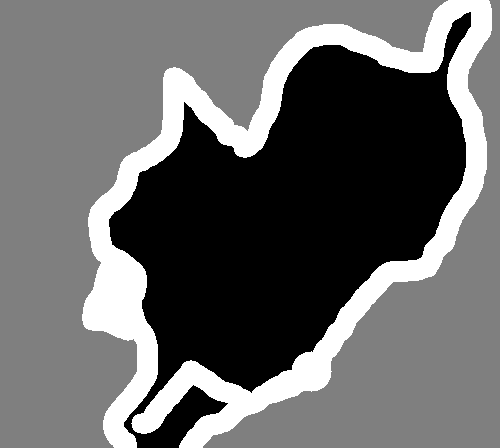

In [5]:
from IPython.display import Image, display
from keras.utils import load_img
from PIL import ImageOps

# Display input image #7
display(Image(filename=input_img_paths[9]))

# Display auto-contrast version of corresponding target (per-pixel categories)
img = ImageOps.autocontrast(load_img(target_img_paths[9]))
display(img)

## 3.5 Preparar dataset y batches de data

In [6]:
import keras
import numpy as np
from tensorflow import data as tf_data
from tensorflow import image as tf_image
from tensorflow import io as tf_io


def get_dataset(
    batch_size,
    img_size,
    input_img_paths,
    target_img_paths,
    max_dataset_len=None,
):
    """Returns a TF Dataset."""

    def load_img_masks(input_img_path, target_img_path):
        input_img = tf_io.read_file(input_img_path)
        input_img = tf_io.decode_png(input_img, channels=3)
        input_img = tf_image.resize(input_img, img_size)
        input_img = tf_image.convert_image_dtype(input_img, "float32")

        target_img = tf_io.read_file(target_img_path)
        target_img = tf_io.decode_png(target_img, channels=1)
        target_img = tf_image.resize(target_img, img_size, method="nearest")
        target_img = tf_image.convert_image_dtype(target_img, "uint8")

        # Ground truth labels are 1, 2, 3. Subtract one to make them 0, 1, 2:
        target_img -= 1
        return input_img, target_img

    # For faster debugging, limit the size of data
    if max_dataset_len:
        input_img_paths = input_img_paths[:max_dataset_len]
        target_img_paths = target_img_paths[:max_dataset_len]
    dataset = tf_data.Dataset.from_tensor_slices((input_img_paths, target_img_paths))
    dataset = dataset.map(load_img_masks, num_parallel_calls=tf_data.AUTOTUNE)
    return dataset.batch(batch_size)


## 3.7 Split de validación

In [7]:
import random

# Split our img paths into a training and a validation set
val_samples = 1000
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

# Instantiate dataset for each split
# Limit input files in `max_dataset_len` for faster epoch training time.
# Remove the `max_dataset_len` arg when running with full dataset.
train_dataset = get_dataset(
    batch_size,
    img_size,
    train_input_img_paths,
    train_target_img_paths,
    max_dataset_len=1000,
)
valid_dataset = get_dataset(
    batch_size, img_size, val_input_img_paths, val_target_img_paths
)

I0000 00:00:1753121617.720982   60953 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3000 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Ti Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


## Entrenamiento con Métricas específicas del dominio

Dependiendo del contexto en el que entrenemos modelos, a veces tiene sentido modificar la métrica de interés. Por ejemplo, en [Image segmentation metrics](https://keras.io/api/metrics/segmentation_metrics/) encontramos:

In [8]:
import tensorflow as tf

def iou_metric(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    return (intersection + smooth) / (union + smooth)

def dice_coefficient(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)


In [9]:
# rafael: converti esto en funcion para manejarlo mas facilmente
def fit_model(model):
  # Configure the model for training.
  # We use the "sparse" version of categorical_crossentropy
  # because our target data is integers.
  model.compile(
      optimizer=keras.optimizers.Adam(1e-4), loss="sparse_categorical_crossentropy",
      metrics=[iou_metric, dice_coefficient]
  )

  callbacks = [
      keras.callbacks.ModelCheckpoint("oxford_segmentation.keras", save_best_only=True),
      keras.callbacks.TensorBoard('./logs', update_freq=1)
  ]

  # Train the model, doing validation at the end of each epoch.
  epochs = 50
  history = model.fit(
      train_dataset,
      epochs=epochs,
      validation_data=valid_dataset,
      callbacks=callbacks,
      verbose=2,
  )
  return model, history

In [10]:
def plot_training(history):
  # Plot training history
  plt.figure(figsize=(12, 4))

  plt.subplot(1, 2, 1)
  plt.plot(history.history['loss'], label='Training Loss')
  plt.plot(history.history['val_loss'], label='Validation Loss')
  plt.title('Model Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(history.history['val_dice_coefficient'], label='Validation Dice')
  plt.plot(history.history['val_iou_metric'], label='Validation IoU')
  plt.title('Custom metrics')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()

In [11]:
from keras.models import load_model
from IPython.display import Image, display

def show_prediction(model, i=10):
  # Generate predictions for all images in the validation set
  val_dataset = get_dataset(
      batch_size, img_size, val_input_img_paths, val_target_img_paths
  )
  val_preds = model.predict(val_dataset)

  def display_mask(i):
      """Quick utility to display a model's prediction."""
      mask = np.argmax(val_preds[i], axis=-1)
      mask = np.expand_dims(mask, axis=-1)
      img = ImageOps.autocontrast(keras.utils.array_to_img(mask))
      display(img)

  # Display input image
  print("HERE",Image)
  display(Image(filename=val_input_img_paths[i]))

  # Display ground-truth target mask
  img = ImageOps.autocontrast(load_img(val_target_img_paths[i]))
  display(img)

  # Display mask predicted by our model
  display_mask(i)  # Note that the model only sees inputs at 150x150.

In [12]:
import os
import pickle
import json
import tensorflow as tf
from tensorflow import keras

def save_experiment(model, history, prefix):
    experiment_dir = f"models/{prefix}"
    os.makedirs(experiment_dir, exist_ok=True)

    model_path = os.path.join(experiment_dir, "model.keras")
    model.save(model_path)

    history_pickle_path = os.path.join(experiment_dir, "history.pkl")
    with open(history_pickle_path, 'wb') as f:
        pickle.dump(history.history, f)

    return experiment_dir


def load_experiment(prefix, load_weights_only=False):
    experiment_dir = f"experiments/{prefix}"

    if not os.path.exists(experiment_dir):
        raise FileNotFoundError(f"Experiment directory not found: {experiment_dir}")

    model = None
    if not load_weights_only:
        model_path = os.path.join(experiment_dir, "model.keras")
        model = keras.models.load_model(model_path)

    history = None
    history_pickle_path = os.path.join(experiment_dir, "history.pkl")
    with open(history_pickle_path, 'rb') as f:
        history = pickle.load(f)

    return model, history, experiment_dir

## Modelos

### Original

In [ ]:
from keras import layers

def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Build model
model = get_model(img_size, num_classes)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 80, 80,    │        896 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 80, 80,    │        128 │ conv2d_10[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_24       │ (None, 80, 80,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_25       │ (None, 80, 80,    │          0 │ activation_24[0]… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_12 │ (None, 80, 80,    │      2,400 │ activation_25[0]… │
│ (SeparableConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 80, 80,    │        256 │ separable_conv2d… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_26       │ (None, 80, 80,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_13 │ (None, 80, 80,    │      4,736 │ activation_26[0]… │
│ (SeparableConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 80, 80,    │        256 │ separable_conv2d… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 40, 40,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 40, 40,    │      2,112 │ activation_24[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_7 (Add)         │ (None, 40, 40,    │          0 │ max_pooling2d_6[… │
│                     │ 64)               │            │ conv2d_11[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_27       │ (None, 40, 40,    │          0 │ add_7[0][0]       │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_14 │ (None, 40, 40,    │      8,896 │ activation_27[0]… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 40, 40,    │        512 │ separable_conv2d… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_28       │ (None, 40, 40,    │          0 │ batch_normalizat

 Total params: 2,058,979 (7.85 MB)

 Trainable params: 2,055,203 (7.84 MB)

 Non-trainable params: 3,776 (14.75 KB)

In [ ]:
model, train_history = fit_model(model)
save_experiment(model,train_history, "original")

Epoch 1/50


I0000 00:00:1753112016.735560   29595 service.cc:152] XLA service 0x713390005110 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753112016.735594   29595 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Ti Laptop GPU, Compute Capability 8.6
2025-07-21 11:33:37.083770: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-07-21 11:33:37.690456: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
I0000 00:00:1753112018.337520   29595 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1753112055.427882   29595 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
Corrupt JPEG data: 240 extraneous bytes before

32/32 - 80s - 3s/step - dice_coefficient: 0.8822 - iou_metric: 0.7897 - loss: 1.1709 - val_dice_coefficient: 0.8604 - val_iou_metric: 0.7553 - val_loss: 1.1569
Epoch 2/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 6s - 197ms/step - dice_coefficient: 0.8661 - iou_metric: 0.7641 - loss: 0.7808 - val_dice_coefficient: 0.8941 - val_iou_metric: 0.8087 - val_loss: 1.1053
Epoch 3/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 6s - 189ms/step - dice_coefficient: 0.8614 - iou_metric: 0.7569 - loss: 0.7011 - val_dice_coefficient: 0.8981 - val_iou_metric: 0.8153 - val_loss: 1.5147
Epoch 4/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 6s - 192ms/step - dice_coefficient: 0.8585 - iou_metric: 0.7523 - loss: 0.6479 - val_dice_coefficient: 0.8986 - val_iou_metric: 0.8162 - val_loss: 2.2006
Epoch 5/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 6s - 190ms/step - dice_coefficient: 0.8573 - iou_metric: 0.7504 - loss: 0.6107 - val_dice_coefficient: 0.8987 - val_iou_metric: 0.8162 - val_loss: 2.9804
Epoch 6/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 6s - 191ms/step - dice_coefficient: 0.8569 - iou_metric: 0.7498 - loss: 0.5785 - val_dice_coefficient: 0.8987 - val_iou_metric: 0.8163 - val_loss: 3.8229
Epoch 7/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 6s - 192ms/step - dice_coefficient: 0.8569 - iou_metric: 0.7499 - loss: 0.5478 - val_dice_coefficient: 0.8987 - val_iou_metric: 0.8163 - val_loss: 4.7258
Epoch 8/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 6s - 190ms/step - dice_coefficient: 0.8575 - iou_metric: 0.7508 - loss: 0.5161 - val_dice_coefficient: 0.8987 - val_iou_metric: 0.8163 - val_loss: 5.7076
Epoch 9/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 6s - 194ms/step - dice_coefficient: 0.8588 - iou_metric: 0.7528 - loss: 0.4836 - val_dice_coefficient: 0.8987 - val_iou_metric: 0.8163 - val_loss: 6.8610
Epoch 10/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 6s - 190ms/step - dice_coefficient: 0.8607 - iou_metric: 0.7557 - loss: 0.4514 - val_dice_coefficient: 0.8987 - val_iou_metric: 0.8163 - val_loss: 8.1989
Epoch 11/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 6s - 193ms/step - dice_coefficient: 0.8630 - iou_metric: 0.7592 - loss: 0.4189 - val_dice_coefficient: 0.8987 - val_iou_metric: 0.8163 - val_loss: 9.5219
Epoch 12/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 6s - 194ms/step - dice_coefficient: 0.8655 - iou_metric: 0.7631 - loss: 0.3872 - val_dice_coefficient: 0.8987 - val_iou_metric: 0.8163 - val_loss: 10.6382
Epoch 13/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 6s - 193ms/step - dice_coefficient: 0.8679 - iou_metric: 0.7669 - loss: 0.3587 - val_dice_coefficient: 0.8987 - val_iou_metric: 0.8163 - val_loss: 11.3470
Epoch 14/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 6s - 195ms/step - dice_coefficient: 0.8706 - iou_metric: 0.7712 - loss: 0.3399 - val_dice_coefficient: 0.8987 - val_iou_metric: 0.8163 - val_loss: 10.9434
Epoch 15/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 6s - 192ms/step - dice_coefficient: 0.8727 - iou_metric: 0.7745 - loss: 0.3729 - val_dice_coefficient: 0.8987 - val_iou_metric: 0.8163 - val_loss: 7.4342
Epoch 16/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 6s - 192ms/step - dice_coefficient: 0.8716 - iou_metric: 0.7727 - loss: 0.3830 - val_dice_coefficient: 0.8987 - val_iou_metric: 0.8162 - val_loss: 4.6004
Epoch 17/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 6s - 195ms/step - dice_coefficient: 0.8713 - iou_metric: 0.7722 - loss: 0.3589 - val_dice_coefficient: 0.8987 - val_iou_metric: 0.8162 - val_loss: 4.2793
Epoch 18/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 6s - 192ms/step - dice_coefficient: 0.8733 - iou_metric: 0.7754 - loss: 0.3294 - val_dice_coefficient: 0.8985 - val_iou_metric: 0.8159 - val_loss: 3.4923
Epoch 19/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 6s - 194ms/step - dice_coefficient: 0.8752 - iou_metric: 0.7784 - loss: 0.3305 - val_dice_coefficient: 0.8961 - val_iou_metric: 0.8120 - val_loss: 1.9865
Epoch 20/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 6s - 193ms/step - dice_coefficient: 0.8750 - iou_metric: 0.7781 - loss: 0.3392 - val_dice_coefficient: 0.8920 - val_iou_metric: 0.8053 - val_loss: 1.5114
Epoch 21/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 6s - 195ms/step - dice_coefficient: 0.8752 - iou_metric: 0.7784 - loss: 0.3352 - val_dice_coefficient: 0.8918 - val_iou_metric: 0.8050 - val_loss: 1.5350
Epoch 22/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 6s - 201ms/step - dice_coefficient: 0.8763 - iou_metric: 0.7802 - loss: 0.3231 - val_dice_coefficient: 0.8809 - val_iou_metric: 0.7874 - val_loss: 0.9094
Epoch 23/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 6s - 202ms/step - dice_coefficient: 0.8775 - iou_metric: 0.7820 - loss: 0.2882 - val_dice_coefficient: 0.8781 - val_iou_metric: 0.7830 - val_loss: 0.8405
Epoch 24/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 6s - 195ms/step - dice_coefficient: 0.8805 - iou_metric: 0.7868 - loss: 0.2699 - val_dice_coefficient: 0.8829 - val_iou_metric: 0.7906 - val_loss: 0.9046
Epoch 25/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 6s - 192ms/step - dice_coefficient: 0.8824 - iou_metric: 0.7898 - loss: 0.2625 - val_dice_coefficient: 0.8817 - val_iou_metric: 0.7886 - val_loss: 0.9168
Epoch 26/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 6s - 196ms/step - dice_coefficient: 0.8835 - iou_metric: 0.7916 - loss: 0.2663 - val_dice_coefficient: 0.8785 - val_iou_metric: 0.7836 - val_loss: 0.9630
Epoch 27/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 6s - 196ms/step - dice_coefficient: 0.8843 - iou_metric: 0.7928 - loss: 0.2777 - val_dice_coefficient: 0.8793 - val_iou_metric: 0.7848 - val_loss: 0.9646
Epoch 28/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 10s - 315ms/step - dice_coefficient: 0.8838 - iou_metric: 0.7921 - loss: 0.2776 - val_dice_coefficient: 0.8818 - val_iou_metric: 0.7888 - val_loss: 0.9882
Epoch 29/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 6s - 194ms/step - dice_coefficient: 0.8837 - iou_metric: 0.7920 - loss: 0.2578 - val_dice_coefficient: 0.8752 - val_iou_metric: 0.7784 - val_loss: 0.8993
Epoch 30/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 6s - 194ms/step - dice_coefficient: 0.8845 - iou_metric: 0.7932 - loss: 0.2349 - val_dice_coefficient: 0.8749 - val_iou_metric: 0.7778 - val_loss: 1.1262
Epoch 31/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 6s - 193ms/step - dice_coefficient: 0.8866 - iou_metric: 0.7966 - loss: 0.2267 - val_dice_coefficient: 0.8779 - val_iou_metric: 0.7826 - val_loss: 1.2639
Epoch 32/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 6s - 194ms/step - dice_coefficient: 0.8879 - iou_metric: 0.7987 - loss: 0.2343 - val_dice_coefficient: 0.8811 - val_iou_metric: 0.7877 - val_loss: 1.1305
Epoch 33/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 6s - 193ms/step - dice_coefficient: 0.8883 - iou_metric: 0.7994 - loss: 0.2452 - val_dice_coefficient: 0.8782 - val_iou_metric: 0.7830 - val_loss: 1.0207
Epoch 34/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 6s - 194ms/step - dice_coefficient: 0.8879 - iou_metric: 0.7987 - loss: 0.2418 - val_dice_coefficient: 0.8797 - val_iou_metric: 0.7854 - val_loss: 0.9952
Epoch 35/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 6s - 199ms/step - dice_coefficient: 0.8881 - iou_metric: 0.7990 - loss: 0.2455 - val_dice_coefficient: 0.8812 - val_iou_metric: 0.7878 - val_loss: 0.9094
Epoch 36/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 6s - 200ms/step - dice_coefficient: 0.8890 - iou_metric: 0.8006 - loss: 0.2224 - val_dice_coefficient: 0.8792 - val_iou_metric: 0.7847 - val_loss: 1.0697
Epoch 37/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 6s - 199ms/step - dice_coefficient: 0.8899 - iou_metric: 0.8019 - loss: 0.2074 - val_dice_coefficient: 0.8794 - val_iou_metric: 0.7850 - val_loss: 1.2191
Epoch 38/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 6s - 195ms/step - dice_coefficient: 0.8911 - iou_metric: 0.8039 - loss: 0.2099 - val_dice_coefficient: 0.8817 - val_iou_metric: 0.7887 - val_loss: 1.1051
Epoch 39/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 6s - 191ms/step - dice_coefficient: 0.8917 - iou_metric: 0.8048 - loss: 0.2172 - val_dice_coefficient: 0.8873 - val_iou_metric: 0.7977 - val_loss: 0.9962
Epoch 40/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 6s - 196ms/step - dice_coefficient: 0.8918 - iou_metric: 0.8050 - loss: 0.2261 - val_dice_coefficient: 0.8935 - val_iou_metric: 0.8077 - val_loss: 1.4132
Epoch 41/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 6s - 196ms/step - dice_coefficient: 0.8904 - iou_metric: 0.8028 - loss: 0.2253 - val_dice_coefficient: 0.8939 - val_iou_metric: 0.8083 - val_loss: 1.5427
Epoch 42/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 6s - 198ms/step - dice_coefficient: 0.8905 - iou_metric: 0.8029 - loss: 0.2098 - val_dice_coefficient: 0.8884 - val_iou_metric: 0.7995 - val_loss: 0.9912
Epoch 43/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 6s - 196ms/step - dice_coefficient: 0.8929 - iou_metric: 0.8068 - loss: 0.1860 - val_dice_coefficient: 0.8888 - val_iou_metric: 0.8001 - val_loss: 0.9439
Epoch 44/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 6s - 195ms/step - dice_coefficient: 0.8947 - iou_metric: 0.8098 - loss: 0.1723 - val_dice_coefficient: 0.8904 - val_iou_metric: 0.8026 - val_loss: 1.0256
Epoch 45/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 6s - 197ms/step - dice_coefficient: 0.8957 - iou_metric: 0.8114 - loss: 0.1660 - val_dice_coefficient: 0.8896 - val_iou_metric: 0.8015 - val_loss: 1.0902
Epoch 46/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 6s - 183ms/step - dice_coefficient: 0.8962 - iou_metric: 0.8122 - loss: 0.1669 - val_dice_coefficient: 0.8884 - val_iou_metric: 0.7995 - val_loss: 1.0713
Epoch 47/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 6s - 187ms/step - dice_coefficient: 0.8966 - iou_metric: 0.8128 - loss: 0.1714 - val_dice_coefficient: 0.8892 - val_iou_metric: 0.8008 - val_loss: 1.1239
Epoch 48/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 6s - 180ms/step - dice_coefficient: 0.8968 - iou_metric: 0.8132 - loss: 0.1798 - val_dice_coefficient: 0.8917 - val_iou_metric: 0.8047 - val_loss: 1.3210
Epoch 49/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 6s - 178ms/step - dice_coefficient: 0.8961 - iou_metric: 0.8121 - loss: 0.1919 - val_dice_coefficient: 0.8933 - val_iou_metric: 0.8075 - val_loss: 1.2466
Epoch 50/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 6s - 180ms/step - dice_coefficient: 0.8955 - iou_metric: 0.8111 - loss: 0.1827 - val_dice_coefficient: 0.8918 - val_iou_metric: 0.8050 - val_loss: 1.1181


In [ ]:
plot_training(train_history)

In [ ]:
show_prediction(model,90)

32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step


TypeError: 'module' object is not callable

### V1 - Removed addition of previous

In [15]:
from keras import layers

def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model

# Build model
modelv1 = get_model(img_size, num_classes)
modelv1.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 80, 80, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 80, 80, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_12 (Activation)      │ (None, 80, 80, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_13 (Activation)      │ (None, 80, 80, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d                │ (None, 80, 80, 64)     │         2,400 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 80, 80, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_14 (Activation)      │ (None, 80, 80, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_1              │ (None, 80, 80, 64)     │         4,736 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 80, 80, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 40, 40, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_15 (Activation)      │ (None, 40, 40, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_2              │ (None, 40, 40, 128)    │         8,896 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 40, 40, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_16 (Activation)      │ (None, 40, 40, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_3              │ (None, 40, 40, 128)    │        17,664 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 40, 40, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_17 (Activation)      │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_4              │ (None, 20, 20, 256)    │        34,176 │
│ (SeparableConv2D)               │                        │             

 Total params: 1,906,499 (7.27 MB)

 Trainable params: 1,902,723 (7.26 MB)

 Non-trainable params: 3,776 (14.75 KB)

In [16]:
model, train_history = fit_model(modelv1)
save_experiment(model,train_history, "v1")

Epoch 1/50


2025-07-21 14:15:57.428908: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
2025-07-21 14:16:22.950255: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
2025-07-21 14:16:37.808911: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
2025-07-21 14:16:39.613774: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


32/32 - 49s - 2s/step - dice_coefficient: 0.7682 - iou_metric: 0.6238 - loss: 1.0110 - val_dice_coefficient: 1.6407e-12 - val_iou_metric: 1.6407e-12 - val_loss: 1.0967
Epoch 2/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 5s - 142ms/step - dice_coefficient: 0.7924 - iou_metric: 0.6564 - loss: 0.7654 - val_dice_coefficient: 0.0520 - val_iou_metric: 0.0267 - val_loss: 1.0495
Epoch 3/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


KeyboardInterrupt: 

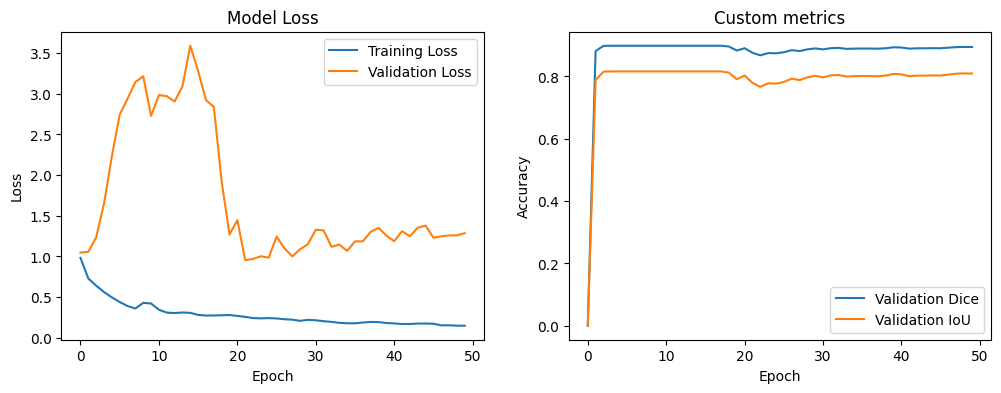

In [ ]:
plot_training(train_history)

32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step
HERE <class 'IPython.core.display.Image'>


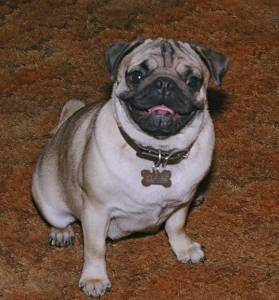

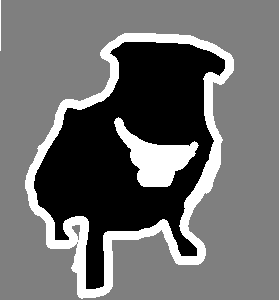

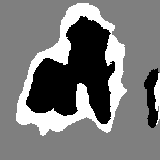

In [ ]:
show_prediction(modelv1,10)

### V2 - Doble convolucion por filtro. Cambio de filtros

In [17]:
from keras import layers

def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))
    x = inputs
    ### [First half of the network: downsampling inputs] ###

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [16, 32, 64, 128]:
        x = layers.Conv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation("relu")(x)

        x = layers.Conv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation("relu")(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

    ### [Second half of the network: upsampling inputs] ###
    for filters in [128, 64, 32, 16]:
        x = layers.UpSampling2D(2)(x)

        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation("relu")(x)

        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation("relu")(x)

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model

# Build model
model = get_model(img_size, num_classes)
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 160, 160, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 160, 160, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_27 (Activation)      │ (None, 160, 160, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 160, 160, 16)   │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 160, 160, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_28 (Activation)      │ (None, 160, 160, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 80, 80, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 80, 80, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 80, 80, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_29 (Activation)      │ (None, 80, 80, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 80, 80, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 80, 80, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_30 (Activation)      │ (None, 80, 80, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 40, 40, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 40, 40, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 40, 40, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_31 (Activation)      │ (None, 40, 40, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 40, 40, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_32          │ (None, 40, 40, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_32 (Activation)      │ (None, 40, 40, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 20, 20, 64)     │             

 Total params: 738,339 (2.82 MB)

 Trainable params: 736,419 (2.81 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [18]:
model, train_history = fit_model(model)
save_experiment(model,train_history, "v2")

Epoch 1/50


2025-07-21 14:17:31.421800: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
2025-07-21 14:17:54.370185: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
2025-07-21 14:18:07.240587: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
2025-07-21 14:18:09.109621: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


32/32 - 45s - 1s/step - dice_coefficient: 0.5849 - iou_metric: 0.4161 - loss: 1.0239 - val_dice_coefficient: 1.6407e-12 - val_iou_metric: 1.6407e-12 - val_loss: 1.0640
Epoch 2/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 5s - 160ms/step - dice_coefficient: 0.7713 - iou_metric: 0.6286 - loss: 0.7977 - val_dice_coefficient: 0.4037 - val_iou_metric: 0.2533 - val_loss: 0.9695
Epoch 3/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 5s - 159ms/step - dice_coefficient: 0.8006 - iou_metric: 0.6676 - loss: 0.6920 - val_dice_coefficient: 0.8900 - val_iou_metric: 0.8020 - val_loss: 0.9509
Epoch 4/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 5s - 157ms/step - dice_coefficient: 0.8017 - iou_metric: 0.6692 - loss: 0.6265 - val_dice_coefficient: 0.8988 - val_iou_metric: 0.8165 - val_loss: 0.9779
Epoch 5/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 5s - 161ms/step - dice_coefficient: 0.8000 - iou_metric: 0.6668 - loss: 0.5770 - val_dice_coefficient: 0.9017 - val_iou_metric: 0.8212 - val_loss: 0.9330
Epoch 6/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 5s - 161ms/step - dice_coefficient: 0.7985 - iou_metric: 0.6647 - loss: 0.5342 - val_dice_coefficient: 0.8921 - val_iou_metric: 0.8055 - val_loss: 0.8554
Epoch 7/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 5s - 162ms/step - dice_coefficient: 0.7975 - iou_metric: 0.6633 - loss: 0.4946 - val_dice_coefficient: 0.8839 - val_iou_metric: 0.7922 - val_loss: 0.8116
Epoch 8/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 5s - 163ms/step - dice_coefficient: 0.7967 - iou_metric: 0.6623 - loss: 0.4575 - val_dice_coefficient: 0.8725 - val_iou_metric: 0.7741 - val_loss: 0.7740
Epoch 9/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 5s - 159ms/step - dice_coefficient: 0.7964 - iou_metric: 0.6619 - loss: 0.4270 - val_dice_coefficient: 0.8628 - val_iou_metric: 0.7589 - val_loss: 0.7541
Epoch 10/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 5s - 142ms/step - dice_coefficient: 0.7965 - iou_metric: 0.6620 - loss: 0.4051 - val_dice_coefficient: 0.8527 - val_iou_metric: 0.7434 - val_loss: 0.7494
Epoch 11/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 5s - 150ms/step - dice_coefficient: 0.8002 - iou_metric: 0.6671 - loss: 0.4050 - val_dice_coefficient: 0.8681 - val_iou_metric: 0.7672 - val_loss: 0.8548
Epoch 12/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 4s - 140ms/step - dice_coefficient: 0.8030 - iou_metric: 0.6711 - loss: 0.4156 - val_dice_coefficient: 0.8348 - val_iou_metric: 0.7167 - val_loss: 0.7308
Epoch 13/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 4s - 140ms/step - dice_coefficient: 0.8050 - iou_metric: 0.6737 - loss: 0.4036 - val_dice_coefficient: 0.8226 - val_iou_metric: 0.6989 - val_loss: 0.7386
Epoch 14/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 4s - 137ms/step - dice_coefficient: 0.8102 - iou_metric: 0.6811 - loss: 0.3912 - val_dice_coefficient: 0.8385 - val_iou_metric: 0.7221 - val_loss: 0.7782
Epoch 15/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 5s - 154ms/step - dice_coefficient: 0.8161 - iou_metric: 0.6895 - loss: 0.3823 - val_dice_coefficient: 0.8534 - val_iou_metric: 0.7445 - val_loss: 0.8429
Epoch 16/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 5s - 160ms/step - dice_coefficient: 0.8237 - iou_metric: 0.7005 - loss: 0.3619 - val_dice_coefficient: 0.8496 - val_iou_metric: 0.7388 - val_loss: 0.7698
Epoch 17/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 5s - 160ms/step - dice_coefficient: 0.8374 - iou_metric: 0.7204 - loss: 0.3491 - val_dice_coefficient: 0.8596 - val_iou_metric: 0.7540 - val_loss: 0.8055
Epoch 18/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 5s - 160ms/step - dice_coefficient: 0.8470 - iou_metric: 0.7347 - loss: 0.3486 - val_dice_coefficient: 0.8632 - val_iou_metric: 0.7595 - val_loss: 0.7897
Epoch 19/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 5s - 159ms/step - dice_coefficient: 0.8517 - iou_metric: 0.7419 - loss: 0.3388 - val_dice_coefficient: 0.8603 - val_iou_metric: 0.7552 - val_loss: 0.7653
Epoch 20/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 5s - 160ms/step - dice_coefficient: 0.8578 - iou_metric: 0.7512 - loss: 0.3154 - val_dice_coefficient: 0.8592 - val_iou_metric: 0.7535 - val_loss: 0.7772
Epoch 21/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 5s - 161ms/step - dice_coefficient: 0.8659 - iou_metric: 0.7636 - loss: 0.2996 - val_dice_coefficient: 0.8582 - val_iou_metric: 0.7518 - val_loss: 0.8237
Epoch 22/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 5s - 159ms/step - dice_coefficient: 0.8715 - iou_metric: 0.7725 - loss: 0.2920 - val_dice_coefficient: 0.8691 - val_iou_metric: 0.7687 - val_loss: 0.8705
Epoch 23/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 5s - 161ms/step - dice_coefficient: 0.8742 - iou_metric: 0.7768 - loss: 0.2922 - val_dice_coefficient: 0.8752 - val_iou_metric: 0.7784 - val_loss: 0.8535
Epoch 24/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 5s - 162ms/step - dice_coefficient: 0.8757 - iou_metric: 0.7791 - loss: 0.2907 - val_dice_coefficient: 0.8739 - val_iou_metric: 0.7763 - val_loss: 0.8515
Epoch 25/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 5s - 164ms/step - dice_coefficient: 0.8755 - iou_metric: 0.7788 - loss: 0.2940 - val_dice_coefficient: 0.8688 - val_iou_metric: 0.7683 - val_loss: 0.9275
Epoch 26/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 5s - 161ms/step - dice_coefficient: 0.8761 - iou_metric: 0.7798 - loss: 0.2839 - val_dice_coefficient: 0.8724 - val_iou_metric: 0.7740 - val_loss: 0.8458
Epoch 27/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 5s - 162ms/step - dice_coefficient: 0.8796 - iou_metric: 0.7854 - loss: 0.2666 - val_dice_coefficient: 0.8760 - val_iou_metric: 0.7795 - val_loss: 0.8090
Epoch 28/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 5s - 165ms/step - dice_coefficient: 0.8834 - iou_metric: 0.7914 - loss: 0.2523 - val_dice_coefficient: 0.8794 - val_iou_metric: 0.7850 - val_loss: 0.8403
Epoch 29/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 5s - 162ms/step - dice_coefficient: 0.8863 - iou_metric: 0.7960 - loss: 0.2482 - val_dice_coefficient: 0.8799 - val_iou_metric: 0.7857 - val_loss: 0.8834
Epoch 30/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 5s - 163ms/step - dice_coefficient: 0.8867 - iou_metric: 0.7968 - loss: 0.2499 - val_dice_coefficient: 0.8781 - val_iou_metric: 0.7830 - val_loss: 1.1591
Epoch 31/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 5s - 162ms/step - dice_coefficient: 0.8866 - iou_metric: 0.7965 - loss: 0.2629 - val_dice_coefficient: 0.8789 - val_iou_metric: 0.7842 - val_loss: 1.0072
Epoch 32/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 5s - 160ms/step - dice_coefficient: 0.8856 - iou_metric: 0.7950 - loss: 0.2649 - val_dice_coefficient: 0.8830 - val_iou_metric: 0.7907 - val_loss: 0.9935
Epoch 33/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 5s - 160ms/step - dice_coefficient: 0.8857 - iou_metric: 0.7952 - loss: 0.2659 - val_dice_coefficient: 0.8842 - val_iou_metric: 0.7927 - val_loss: 1.0679
Epoch 34/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 5s - 159ms/step - dice_coefficient: 0.8843 - iou_metric: 0.7929 - loss: 0.2814 - val_dice_coefficient: 0.8807 - val_iou_metric: 0.7870 - val_loss: 0.9252
Epoch 35/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 5s - 165ms/step - dice_coefficient: 0.8834 - iou_metric: 0.7913 - loss: 0.2710 - val_dice_coefficient: 0.8830 - val_iou_metric: 0.7908 - val_loss: 0.8428
Epoch 36/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 5s - 166ms/step - dice_coefficient: 0.8849 - iou_metric: 0.7938 - loss: 0.2514 - val_dice_coefficient: 0.8881 - val_iou_metric: 0.7990 - val_loss: 0.9020
Epoch 37/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 5s - 161ms/step - dice_coefficient: 0.8880 - iou_metric: 0.7988 - loss: 0.2316 - val_dice_coefficient: 0.8914 - val_iou_metric: 0.8043 - val_loss: 1.0642
Epoch 38/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 5s - 161ms/step - dice_coefficient: 0.8903 - iou_metric: 0.8025 - loss: 0.2224 - val_dice_coefficient: 0.8941 - val_iou_metric: 0.8088 - val_loss: 1.1788
Epoch 39/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 5s - 166ms/step - dice_coefficient: 0.8919 - iou_metric: 0.8052 - loss: 0.2184 - val_dice_coefficient: 0.8920 - val_iou_metric: 0.8053 - val_loss: 0.9880
Epoch 40/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 5s - 162ms/step - dice_coefficient: 0.8934 - iou_metric: 0.8077 - loss: 0.2133 - val_dice_coefficient: 0.8891 - val_iou_metric: 0.8005 - val_loss: 0.9032
Epoch 41/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 5s - 163ms/step - dice_coefficient: 0.8943 - iou_metric: 0.8092 - loss: 0.2151 - val_dice_coefficient: 0.8888 - val_iou_metric: 0.8000 - val_loss: 0.9257
Epoch 42/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 5s - 165ms/step - dice_coefficient: 0.8942 - iou_metric: 0.8090 - loss: 0.2209 - val_dice_coefficient: 0.8915 - val_iou_metric: 0.8045 - val_loss: 0.9178
Epoch 43/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 5s - 164ms/step - dice_coefficient: 0.8937 - iou_metric: 0.8081 - loss: 0.2245 - val_dice_coefficient: 0.8940 - val_iou_metric: 0.8085 - val_loss: 1.0927
Epoch 44/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 5s - 165ms/step - dice_coefficient: 0.8933 - iou_metric: 0.8074 - loss: 0.2297 - val_dice_coefficient: 0.8948 - val_iou_metric: 0.8098 - val_loss: 1.2201
Epoch 45/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 5s - 162ms/step - dice_coefficient: 0.8934 - iou_metric: 0.8077 - loss: 0.2170 - val_dice_coefficient: 0.8955 - val_iou_metric: 0.8110 - val_loss: 1.3111
Epoch 46/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 5s - 164ms/step - dice_coefficient: 0.8943 - iou_metric: 0.8090 - loss: 0.2129 - val_dice_coefficient: 0.8957 - val_iou_metric: 0.8113 - val_loss: 1.1660
Epoch 47/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 5s - 164ms/step - dice_coefficient: 0.8951 - iou_metric: 0.8104 - loss: 0.2070 - val_dice_coefficient: 0.8945 - val_iou_metric: 0.8094 - val_loss: 1.0476
Epoch 48/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 5s - 165ms/step - dice_coefficient: 0.8956 - iou_metric: 0.8112 - loss: 0.2054 - val_dice_coefficient: 0.8934 - val_iou_metric: 0.8075 - val_loss: 1.0505
Epoch 49/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 5s - 163ms/step - dice_coefficient: 0.8952 - iou_metric: 0.8106 - loss: 0.2204 - val_dice_coefficient: 0.8919 - val_iou_metric: 0.8051 - val_loss: 1.0161
Epoch 50/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 5s - 164ms/step - dice_coefficient: 0.8946 - iou_metric: 0.8096 - loss: 0.2182 - val_dice_coefficient: 0.8929 - val_iou_metric: 0.8068 - val_loss: 1.0668


'models/v2'

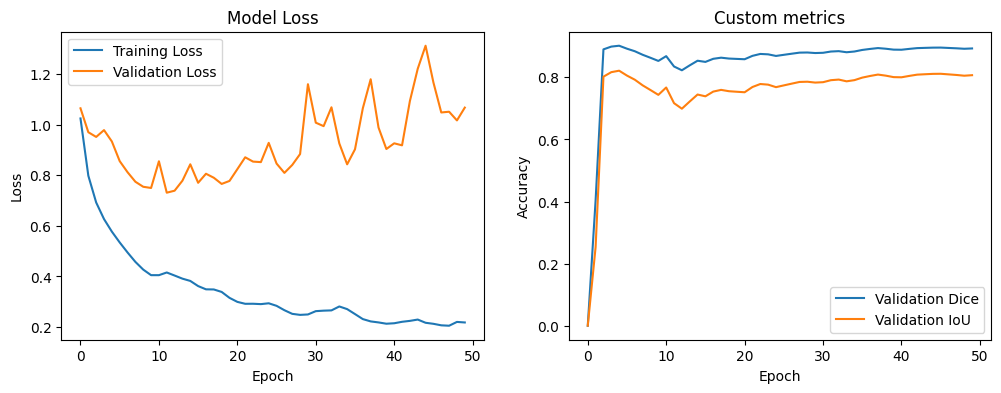

In [19]:
plot_training(train_history)

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
HERE <class 'IPython.core.display.Image'>


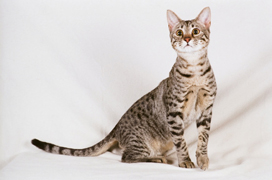

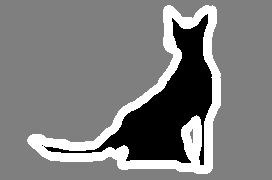

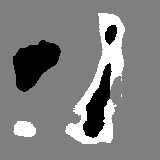

In [25]:
show_prediction(model,35)

In [18]:
from keras import layers

def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model

# Build model
modelv1 = get_model(img_size, num_classes)
modelv1.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 80, 80, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_36          │ (None, 80, 80, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_36 (Activation)      │ (None, 80, 80, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_37 (Activation)      │ (None, 80, 80, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d                │ (None, 80, 80, 64)     │         2,400 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_37          │ (None, 80, 80, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_38 (Activation)      │ (None, 80, 80, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_1              │ (None, 80, 80, 64)     │         4,736 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_38          │ (None, 80, 80, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 40, 40, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_39 (Activation)      │ (None, 40, 40, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_2              │ (None, 40, 40, 128)    │         8,896 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_39          │ (None, 40, 40, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_40 (Activation)      │ (None, 40, 40, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_3              │ (None, 40, 40, 128)    │        17,664 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_40          │ (None, 40, 40, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_41 (Activation)      │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_4              │ (None, 20, 20, 256)    │        34,176 │
│ (SeparableConv2D)               │                        │             

 Total params: 1,906,499 (7.27 MB)

 Trainable params: 1,902,723 (7.26 MB)

 Non-trainable params: 3,776 (14.75 KB)

In [ ]:
model, train_history = fit_model(modelv1)
save_experiment(model,train_history, "v1")

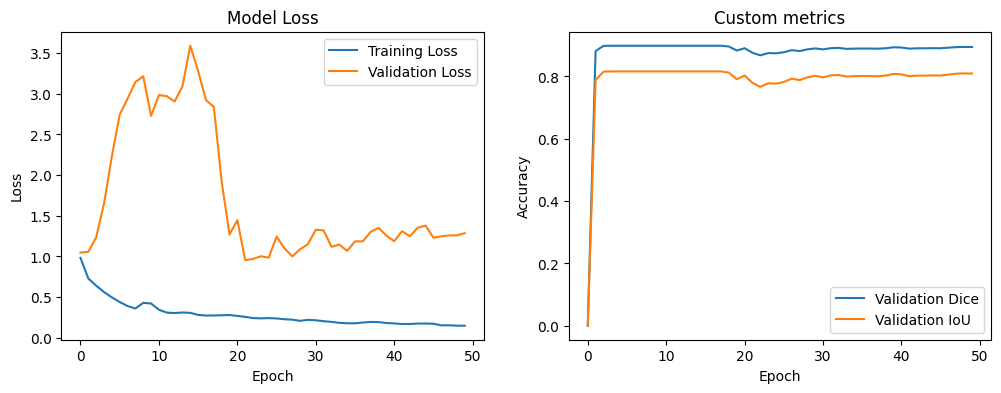

In [ ]:
plot_training(train_history)

32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step
HERE <class 'IPython.core.display.Image'>


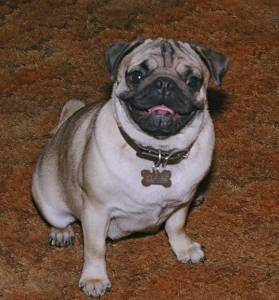

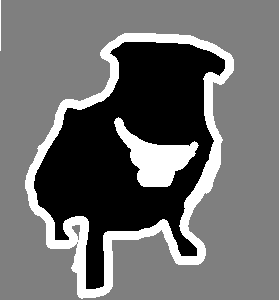

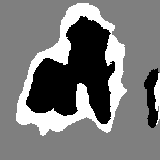

In [ ]:
show_prediction(modelv1,10)

### V2 - Doble convolucion por filtro. Cambio de filtros

In [30]:
from keras import layers

def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))
    x = inputs
    ### [First half of the network: downsampling inputs] ###

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [32, 64, 128, 256]:
        x = layers.Conv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation("relu")(x)

        x = layers.Conv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation("relu")(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

    ### [Second half of the network: upsampling inputs] ###
    for filters in [256, 128, 64, 32]:
        x = layers.UpSampling2D(2)(x)

        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation("relu")(x)

        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation("relu")(x)

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model

# Build model
model = get_model(img_size, num_classes)
model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_57 (Conv2D)              │ (None, 160, 160, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_115         │ (None, 160, 160, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_115 (Activation)     │ (None, 160, 160, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_58 (Conv2D)              │ (None, 160, 160, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_116         │ (None, 160, 160, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_116 (Activation)     │ (None, 160, 160, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 80, 80, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_59 (Conv2D)              │ (None, 80, 80, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_117         │ (None, 80, 80, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_117 (Activation)     │ (None, 80, 80, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_60 (Conv2D)              │ (None, 80, 80, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_118         │ (None, 80, 80, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_118 (Activation)     │ (None, 80, 80, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 40, 40, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_61 (Conv2D)              │ (None, 40, 40, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_119         │ (None, 40, 40, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_119 (Activation)     │ (None, 40, 40, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_62 (Conv2D)              │ (None, 40, 40, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_120         │ (None, 40, 40, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_120 (Activation)     │ (None, 40, 40, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_30 (MaxPooling2D) │ (None, 20, 20, 128)    │             

 Total params: 2,942,019 (11.22 MB)

 Trainable params: 2,938,179 (11.21 MB)

 Non-trainable params: 3,840 (15.00 KB)

In [27]:
model, train_history = fit_model(model)
save_experiment(model,train_history, "v2")

Epoch 1/50


ValueError: Arguments `target` and `output` must have the same shape up until the last dimension: target.shape=(None, 160, 160), output.shape=(None, 256, 256, 3)

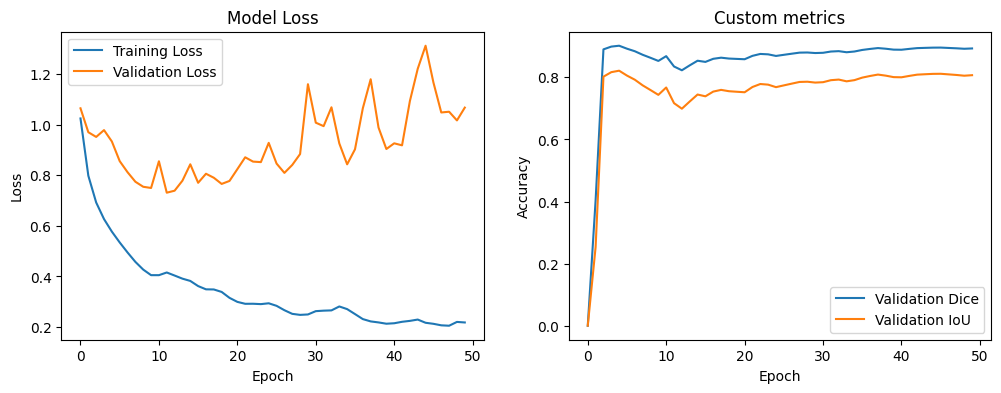

In [ ]:
plot_training(train_history)

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
HERE <class 'IPython.core.display.Image'>


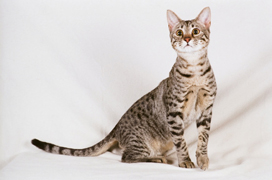

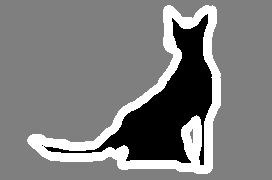

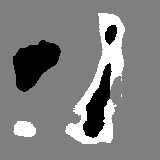

In [ ]:
show_prediction(model,35)

In [ ]:
from keras import layers

def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model

# Build model
modelv1 = get_model(img_size, num_classes)
modelv1.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 80, 80, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_36          │ (None, 80, 80, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_36 (Activation)      │ (None, 80, 80, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_37 (Activation)      │ (None, 80, 80, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d                │ (None, 80, 80, 64)     │         2,400 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_37          │ (None, 80, 80, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_38 (Activation)      │ (None, 80, 80, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_1              │ (None, 80, 80, 64)     │         4,736 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_38          │ (None, 80, 80, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 40, 40, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_39 (Activation)      │ (None, 40, 40, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_2              │ (None, 40, 40, 128)    │         8,896 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_39          │ (None, 40, 40, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_40 (Activation)      │ (None, 40, 40, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_3              │ (None, 40, 40, 128)    │        17,664 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_40          │ (None, 40, 40, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_41 (Activation)      │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_4              │ (None, 20, 20, 256)    │        34,176 │
│ (SeparableConv2D)               │                        │             

 Total params: 1,906,499 (7.27 MB)

 Trainable params: 1,902,723 (7.26 MB)

 Non-trainable params: 3,776 (14.75 KB)

In [ ]:
model, train_history = fit_model(modelv1)
save_experiment(model,train_history, "v1")

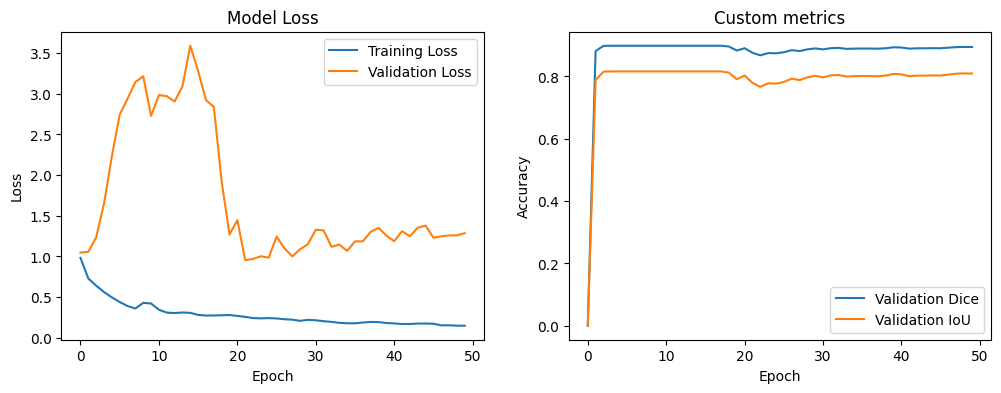

In [ ]:
plot_training(train_history)

32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step
HERE <class 'IPython.core.display.Image'>


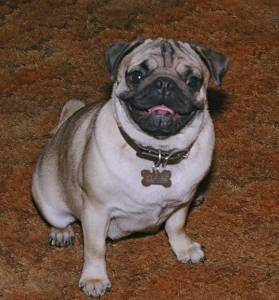

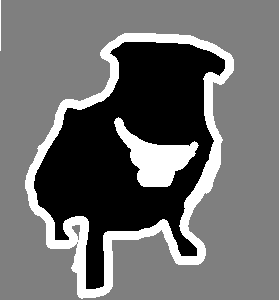

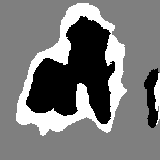

In [ ]:
show_prediction(modelv1,10)